<a href="https://colab.research.google.com/github/ethansong206/Climate-Plus-Project/blob/main/DataCleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import necessary packages for the code

---

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import seaborn
import matplotlib.pyplot as plt

---
Load the Duke Dining csv file and make the data easier to handle. This includes but is not limited to:

1) Renaming locations

2) Changing the date from a string to a date object

---

In [2]:
DiningDataFull = pd.read_csv('Climate+ Data 2019 thru 2023.csv', 
                             dtype = {'Priority 1': str, 'Priority 2': str,
                                      'Priority 3': str})
#print(DiningDataFull['Unit Name'].value_counts()) # Show how many entries there are of each location

#below code to make 'Unit Name' column easier to handle
#can add more lines given more locations
def location_rename(location):
    if("Marketplace" in location): #Combine data for Marketplace Kitchen and Marketplace Special Event
        return "Marketplace"
    if("Marine Lab" in location):
        return "DuML"
    if("Trinity" in location):
        return "Trinity"
    if("Freeman" in location):
        return "Freeman"
    return None

DiningDataFull['Unit Name'] = DiningDataFull.apply(lambda d: location_rename(d['Unit Name']), axis = 1)

DiningDataFull['Purchase Date'] = DiningDataFull.apply(lambda d: datetime.strptime(d['Purchase Date'], '%m/%d/%Y').date(), axis = 1)

print("Rows in DiningDataFull: ", DiningDataFull.shape[0])

Rows in DiningDataFull:  90534


---
Extract the unit names for each item into a new column called `Unit`, then rename each unit into a more simple label (i.e. LB CS to LB). Convert cans and bottle cases into the equivalent value in OZ.

Extract the simplified item name from `Vendor Item Description` into a new column called `Item Name`.

---
Note on Exclusion: Some units are left out in this first calculation of emissions as they are either not directly food (i.e. gloves) or are too difficult to go through individually and find a measurement that is not ambiguous. The total number of entries left out is 12171. **The number of non-food items in this amount can be calculated later.**

---
Note on Conversions: The column `Vendor Item Purchase Unit` is in the format x/y n which should be read as x bags of y units of n food.

---

In [3]:
#this code extracts just the unit information
DiningDataFull['Unit'] = DiningDataFull['Vendor Item Purchase Unit'].str.extract(r" ?([A-Za-zÀ-ÿ ]*)$").astype(str)
#below code to simplify redundant labels (i.e. LB CS to LB)
def unit_rename(unit):
    if('LB' in unit) | ('lb' in unit) | ('Lb' in unit) | ('Pound' in unit):
        return 'LB'
    if('OZ' in unit) | ('oz' in unit) | ('Oz' in unit) | (' Z' in unit):
        return 'OZ'
    if('GA' in unit) | ('Gal' in unit):
        return 'GA'
    if('QT' in unit):
        return 'QT'
    if('PT' in unit) | ('Pint' in unit) | ('PINT' in unit):
        return 'PT'
    if('LT' in unit):
        return 'LT' 
    if('BU' in unit) | ('Bushel' in unit): #bushels
        return 'BU'
    if('KG' in unit):
        return 'KG' 
    if('GR' in unit): #grams
        return 'GR' 
    if('ML' in unit) | ('ml' in unit) | ('Ml' in unit): #milliliters
        return 'ML'
    if('CN' in unit) | ('Can' in unit):
        return 'CN'
    if('Bottle Case' in unit):
        return 'Bottle Case'
    return None
#Notes: Bottle Case is 64 oz each, find # of can and translate to oz, anything with EA is not included for now (~9000)
DiningDataFull['Unit'] = DiningDataFull.apply(lambda d: unit_rename(d['Unit']), axis = 1)

#convert cans to OZ
#using estimates for weight of cans through https://food.unl.edu/article/how-interpret-can-size-numbers
DiningDataFull = DiningDataFull.replace({'#10 CN' : '110.5 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'#10 Can' : '110.5 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'#300 CN' : '15 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'CN' : 'OZ'})
#convert bottle case to OZ
DiningDataFull = DiningDataFull.replace({' Bottle Case' : '/64 OZ'}, regex = True)
DiningDataFull = DiningDataFull.replace({'Bottle Case' : 'OZ'})

#extract item names
#make everything uppercase and remove zz's in front of some of the item descriptions
DiningDataFull['Vendor Item Description'] = DiningDataFull['Vendor Item Description'].str.upper()
DiningDataFull['Vendor Item Description'] = DiningDataFull['Vendor Item Description'].str.extract(r'Z?Z? ?(.*)')
DiningDataFull['Vendor Item'] = DiningDataFull['Vendor Item Description'].str.extract(r'(.*),')
DiningDataFull['Vendor Item'] = DiningDataFull['Vendor Item'].str.upper()
print(DiningDataFull.head())

     Unit Name    Vendor Purchase Date Vendor Item ID  \
0  Marketplace  US Foods    2019-07-01        5018999   
1  Marketplace  US Foods    2019-07-01        5400692   
2  Marketplace  US Foods    2019-07-01        8012643   
3  Marketplace  US Foods    2019-07-01         731349   
4  Marketplace  US Foods    2019-07-01          68106   

                             Vendor Item Description  \
0  POTATO, FRENCH-FRY 3/4 X3/8 STEAK CUT SKIN-ON ...   
1  POTATO, FRENCH-FRY SPIRAL COATED SEASONED TFF ...   
2  POTATO, FRENCH-FRY 1/2 CRINKLE-CUT TFF EXTRA-L...   
3                POTATO, HASH BROWN SHRED COOKED REF   
4    POTATO, TATER NUGGET PARFRIED FROZEN HASH BROWN   

  Vendor Item Purchase Unit                              Product Group  \
0                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
1                    6/5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
2                  6/4.5 LB  APPETIZERS, ENTREES, & POTATOES REF & FZN   
3                   2/10

---
Make a new column called `Total Amount` for the total amount of food in the current unit of measurement, before converting to grams. Make a new column called `Total Amount(g)` for converting all units to the equivalent value in grams, then filter out main descriptor word(s) in `Vendor Item Description` into a new column called `Food Name`.

---

Take the column with units in grams and multiply by the `Receive Quantity` if provided into a new column called `Total Grams`. If there is no value in `Receive Quantity`, then assume it is the value 1.

---
Note on Conversions: Most of these conversions are estimated to the nearest tenth. **More accurate calculations can be found later**

---

In [4]:
#make a new dataset for just entries with known units
DDReduced = DiningDataFull[DiningDataFull['Unit'].notna()]
#print(DDReduced.head())

#find total amount of food before converting to grams
DDReduced = DDReduced.copy()
DDReduced['Total Amount'] = DDReduced['Vendor Item Purchase Unit'].str.extract(r'^[a-zA-Z]* ?-?/? ?([0-9]*/?[0-9.]*-?[0-9.]*)')
DDReduced['Range'] = DDReduced['Total Amount'].str.extract(r'([0-9.]*-[0-9.]*)')
DDReduced['Range'] = DDReduced['Range'].astype(str)
DDReduced['Range'] = DDReduced['Range'].replace({'nan' : '0'})
DDReduced['Range Average'] = DDReduced['Range'].replace({'-' : '+'}, regex = True)
DDReduced['Range Average'] = DDReduced.apply(lambda d: eval(d['Range Average']), axis = 1)
DDReduced['Range Average'] /= 2

has_slash = ~(DDReduced['Total Amount'].str.contains('/')) & (DDReduced['Total Amount'].str.len() > 0)
DDReduced.loc[has_slash, 'Total Amount'] = (
    '1/' + DDReduced.loc[has_slash, 'Total Amount']
)

has_range = DDReduced['Total Amount'].str.contains('-')
DDReduced.loc[has_range, 'Total Amount'] = (
    DDReduced.loc[has_range, 'Total Amount'].str.split('/').str[0]
    + '/'
    + DDReduced.loc[has_range, 'Range Average'].astype(str)
)

just_unit = (DDReduced['Total Amount'] == '') & ~(DDReduced['Vendor Item Purchase Unit'].isna())
DDReduced.loc[just_unit, 'Total Amount'] = '1'

DDReduced = DDReduced.drop(['Range', 'Range Average'], axis = 1)

DDReduced['Total Amount'] = DDReduced['Total Amount'].replace({'' : '0'})
DDReduced['Receive Quantity'] = DDReduced['Receive Quantity'].fillna(0)
DDReduced = DDReduced[DDReduced['Receive Quantity'] != 0] #get rid of any rows that were not received
DDReduced['Total Amount'] = DDReduced['Total Amount'].replace({'/' : '*'}, regex = True)
DDReduced['Total Amount'] = DDReduced.apply(lambda d: eval(d['Total Amount']), axis = 1)
DDReduced['Total Amount'] = DDReduced['Total Amount'].astype(float) * DDReduced['Receive Quantity'].astype(float)

#convert units to grams
def convert_units(row):
    if row['Unit'] == 'LB':
        return row['Total Amount'] * 453.6
    if row['Unit'] == 'OZ':
        return row['Total Amount'] * 28.35
    if row['Unit'] == 'GA':
        return row['Total Amount'] * 3785.4 #assuming density of water, most drinks are MORE dense so number is underestimate
    if row['Unit'] == 'QT':
        return row['Total Amount'] * 3785.4 / 4
    if row['Unit'] == 'PT':
        return row['Total Amount'] * 3785.4 / 8
    if (row['Unit'] == 'LT') | (row['Unit'] == 'KG'):
        return row['Total Amount'] * 1000 #also assuming density of water, most drinks MORE dense
    if row['Unit'] == 'BU':
        return row['Total Amount'] * 32.5 * 453.6 #average of 40lbs per bu apples, squash, etc. and 25lbs per bu peppers, etc.
    if (row['Unit'] == 'ML') | (row['Unit'] == 'G'):
        return row['Total Amount'] * 453.6
    return 0
DDReduced['Total Amount(g)'] = DDReduced.apply(convert_units, axis = 1)
DDReduced['Total Amount(kg)'] = DDReduced['Total Amount(g)'] / 1000

#modify `Product Group` column
DDReduced = DDReduced[DDReduced['Product Group'].notna()]
DDReduced['Product Group'] = DDReduced['Product Group'].str.upper() #make uppercase to simplify code

print("Excluded rows: ", DiningDataFull.shape[0] - DDReduced.shape[0])
#print(DDReduced.head())

<ipython-input-4-1aeab029a4c0>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DDReduced['Total Amount'] = DDReduced['Total Amount'].replace({'/' : '*'}, regex = True)


Excluded rows:  17177


<ipython-input-4-1aeab029a4c0>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DDReduced['Product Group'] = DDReduced['Product Group'].str.upper() #make uppercase to simplify code


---
#More item name cleaning

---

In [5]:
#label others meats that are not already labeled
meat_not_labeled = (DDReduced['Product Group'].str.contains('MEAT', regex = True) | \
                    DDReduced['Product Group'].str.contains('MEATS', regex = True)) & \
                    ~(DDReduced['Product Group'].str.contains('SUBSTITUTE', regex = True)) 
                    #mask meats not labeled, but not substitutes
vendor_item_na = (DDReduced['Vendor Item'].isna())

#if meat not labeled, but `Vendor Item` is NaN, read first word of `Vendor Item Description`
DDReduced.loc[meat_not_labeled & vendor_item_na, 'Vendor Item'] = \
    (DDReduced.loc[meat_not_labeled & vendor_item_na, 'Vendor Item Description'].str.split(' ').str[0])

#meat substitute labeling part 1
is_meat_sub = (DDReduced['Vendor Item'].str.contains('SUB')) | \
              (DDReduced['Vendor Item'] == 'BEAN')
DDReduced.loc[is_meat_sub & meat_not_labeled, 'Product Group'] = 'MEAT SUBSTITUTE'

#dictionary of known meats, if not in dictionary, read next word
meat_dict = ['SUB', 'BEAN', 'SAUSAGE', 'PEPPERONI', 'HOT DOG', 'CORN DOG', \
             'DOG', 'SALAMI', 'MEATBALL', 'CHICKEN', 'TURKEY', 'DUCK', \
             'CORNISH HEN', 'BEEF', 'CORNED BEEF', 'ROAST', 'PASTRAMI', \
             'GYRO MEAT', 'LAMB', 'PORK', 'HAM', 'BACON', 'CRAB CAKE', \
             'CRABMEAT', 'COD', 'SALMON', 'MAHI MAHI', 'SHRIMP', 'TUNA', \
             'CATFISH', 'MUSSEL', 'FLOUNDER', 'FISH', 'SURIMI', 'POLLOCK', \
             'SCALLOP', 'LOBSTER', 'GROUPER', 'CRAWFISH', 'ALL-BEEF', 'CHUCK']
meat_in_dict = ~DDReduced['Vendor Item'].isin(meat_dict)

#iterate through words until meat is found
def extract_vendor_item(description):
    words = description.split()
    for word in words:
        if word in meat_dict:
            return word
    return
DDReduced.loc[meat_in_dict & meat_not_labeled, 'Vendor Item'] = \
        DDReduced.loc[meat_in_dict & meat_not_labeled, 'Vendor Item Description'].apply(lambda x: extract_vendor_item(x))

#label meat sub again if missed in first run
is_meat_sub = (DDReduced['Vendor Item'].str.contains('SUB')) | \
              (DDReduced['Vendor Item'] == 'BEAN')
DDReduced.loc[is_meat_sub & meat_not_labeled, 'Product Group'] = 'MEAT SUBSTITUTE'

#label sausage and sausage-related foods
sausage_like = (DDReduced['Vendor Item'].str.contains('SAUSAGE')) | \
               (DDReduced['Vendor Item'] == 'PEPPERONI') | \
               (DDReduced['Vendor Item'].str.contains('DOG')) | \
               (DDReduced['Vendor Item'] == 'SALAMI')
DDReduced.loc[sausage_like, 'Product Group'] = 'SAUSAGE'

#label meatballs (half pork, half beef)
is_meatball = (DDReduced['Vendor Item'] == 'MEATBALL')
DDReduced.loc[is_meatball, 'Product Group'] = 'MEATBALL'

#label poultry
is_poultry = (DDReduced['Vendor Item'] == 'CHICKEN') | \
             (DDReduced['Vendor Item'] == 'TURKEY') | \
             (DDReduced['Vendor Item'] == 'DUCK') | \
             (DDReduced['Vendor Item'].str.contains('HEN'))
DDReduced.loc[is_poultry & meat_not_labeled, 'Product Group'] = 'POULTRY'

#label beef
is_beef = (DDReduced['Vendor Item'].str.contains('BEEF')) | \
          (DDReduced['Vendor Item'].str.contains('ROAST')) | \
          (DDReduced['Vendor Item'] == 'PASTRAMI') | \
          (DDReduced['Vendor Item'] == 'CHUCK')
DDReduced.loc[is_beef & meat_not_labeled, 'Product Group'] = 'BEEF'

#label gyro meat
is_gyro_meat = (DDReduced['Vendor Item'].str.contains('GYRO MEAT')) | \
               (DDReduced['Vendor Item'] == 'LAMB')
DDReduced.loc[is_gyro_meat & meat_not_labeled, 'Product Group'] = 'LAMB' 
#most common ingredient in gyro meat, technically has beef but the numbers are very similar

#label pork
is_pork = (DDReduced['Vendor Item'] == 'PORK') | \
          (DDReduced['Vendor Item'] == 'HAM') | \
          (DDReduced['Vendor Item'] == 'BACON')
DDReduced.loc[is_pork & meat_not_labeled, 'Product Group'] = 'PORK'

#label seafood
is_seafood = (DDReduced['Vendor Item'].str.contains('CRAB')) | \
          (DDReduced['Vendor Item'] == 'COD') | \
          (DDReduced['Vendor Item'] == 'SALMON') | \
          (DDReduced['Vendor Item'] == 'MAHI MAHI') | \
          (DDReduced['Vendor Item'] == 'SHRIMP') | \
          (DDReduced['Vendor Item'] == 'TUNA') | \
          (DDReduced['Vendor Item'] == 'CATFISH') | \
          (DDReduced['Vendor Item'] == 'MUSSEL') | \
          (DDReduced['Vendor Item'] == 'FLOUNDER') | \
          (DDReduced['Vendor Item'] == 'FISH') | \
          (DDReduced['Vendor Item'] == 'SURIMI') | \
          (DDReduced['Vendor Item'] == 'POLLOCK') | \
          (DDReduced['Vendor Item'] == 'SCALLOP') | \
          (DDReduced['Vendor Item'] == 'LOBSTER') | \
          (DDReduced['Vendor Item'] == 'GROUPER') | \
          (DDReduced['Vendor Item'] == 'CRAWFISH')
#Surimi is made of fish
DDReduced.loc[is_seafood & meat_not_labeled, 'Product Group'] = 'SEAFOOD'

#label sodas
is_soda = DDReduced['Brand'] == 'Durham Coca Cola'
DDReduced.loc[is_soda, 'Product Group'] = 'SODA'

#print((DDReduced.iloc[45284]))

---
#Explore Data

---

In [6]:
#print(DDReduced[(DDReduced['Product Group'] == 'Beverages') & (DDReduced['Vendor Item'].isna())][0:20])
print(DDReduced[DDReduced['Product Group'] == '651401 LOCAL MEATS'])

Empty DataFrame
Columns: [Unit Name, Vendor, Purchase Date, Vendor Item ID, Vendor Item Description, Vendor Item Purchase Unit, Product Group, Brand, Receive Quantity, Priority 1, Priority 2, Priority 3, Unit, Vendor Item, Total Amount, Total Amount(g), Total Amount(kg)]
Index: []


---
####Load the csv with CO2 numbers and find numbers for carbon emissions

---

In [7]:
CO2 = pd.read_csv('CO2 values for FACCWTHA v1.1 - Foods.csv')

#replace values below if need to update values
#CURRENT VALUES: from CO2 spreadsheet above (Poore and Nemecek 2018) (6/5/23)
beef_emission_ratio = 21.3 #US for retail beef, 65% of CW, https://www.sciencedirect.com/science/article/pii/S0308521X18305675?via%3Dihub#s0085
pork_emission_ratio = 10 #pork (PN18)
poultry_emission_ratio = 4.9 #chicken for North America (PN18)
lamb_emission_ratio = 40.0 #using global avg, lower than europe avg.
seafood_emission_ratio = CO2[CO2['FoodAisle'] == 'Fish']['CO2eRatioSLBBook'].mean() #average of three common fish
eggs_emission_ratio = 3.7 #avg for US (PN18)
meatsub_emission_ratio = 2.19 #(https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9936781/ , Mejia et al., 2020)
meatball_emission_ratio = .5 * beef_emission_ratio + .5 * pork_emission_ratio
sausage_emission_ratio = 6.4 #Ph.D. thesis Frankowska 2019, which is a more recent calculation
#add more values here as the data gets more clean
#later, replace means/averages with weighted averages depending on how often eaten and average amount eaten each instance

print("beef: ", beef_emission_ratio, 'kg CO2e/kg')
print("pork: ", pork_emission_ratio, 'kg CO2e/kg')
print("poultry: ", poultry_emission_ratio, 'kg CO2e/kg')
print("lamb: ", lamb_emission_ratio, 'kg CO2e/kg')
print("seafood: ", seafood_emission_ratio, 'kg CO2e/kg')
print("eggs: ", eggs_emission_ratio, 'kg CO2e/kg')
print("meatsub: ", meatsub_emission_ratio, 'kg CO2e/kg')
print("meatball: ", meatball_emission_ratio, 'kg CO2e/kg')
print("sausage: ", sausage_emission_ratio, 'kg CO2e/kg')

#print(CO2.head())

beef:  21.3 kg CO2e/kg
pork:  10 kg CO2e/kg
poultry:  4.9 kg CO2e/kg
lamb:  40.0 kg CO2e/kg
seafood:  5.133333333333334 kg CO2e/kg
eggs:  3.7 kg CO2e/kg
meatsub:  2.19 kg CO2e/kg
meatball:  15.65 kg CO2e/kg
sausage:  6.4 kg CO2e/kg


---
#CALCULATING CARBON EMISSIONS

Currently includes: Meats, Meat Alternatives, and Eggs

NOTE: 651400 meats, 651401 local meats, processed meat, and specialty meats are excluded as of now, for a total of 3964 rows

---

In [8]:
#print(DDReduced['Product Group'].value_counts())

def calc_emissions(row):
    if row['Product Group'] == 'BEEF':
        return row['Total Amount(kg)'] * beef_emission_ratio
    if row['Product Group'] == 'PORK':
        return row['Total Amount(kg)'] * pork_emission_ratio
    if row['Product Group'] == 'SEAFOOD':
        return row['Total Amount(kg)'] * seafood_emission_ratio
    if row['Product Group'] == 'MEAT SUBSTITUTE':
        return row['Total Amount(kg)'] * meatsub_emission_ratio
    if row['Product Group'] == 'LAMB':
        return row['Total Amount(kg)'] * lamb_emission_ratio
    if (row['Product Group'] == 'CHICKEN') | (row['Product Group'] == 'POULTRY') | \
       (row['Product Group'] == 'TURKEY') | (row['Product Group'] == 'DUCK'):
        return row['Total Amount(kg)'] * beef_emission_ratio
    if row['Product Group'] == 'EGGS':
        return row['Total Amount(kg)'] * eggs_emission_ratio
    if row['Product Group'] == 'MEATBALL':
        return row['Total Amount(kg)'] * meatball_emission_ratio
    if row['Product Group'] == 'SAUSAGE':
        return row['Total Amount(kg)'] * sausage_emission_ratio
    return 0

DDReduced['CO2e(kg)'] = DDReduced.apply(calc_emissions, axis = 1)

total_food_amount_kg = DDReduced['Total Amount(kg)'].sum()
total_food_amount_calced_kg = DDReduced[DDReduced['CO2e(kg)'] != 0]['Total Amount(kg)'].sum()
percent_food_calced = total_food_amount_calced_kg / total_food_amount_kg * 100

print('The percentage of food (by weight) with calculated carbon emissions so far is: ', percent_food_calced, "%")

The percentage of food (by weight) with calculated carbon emissions so far is:  63.20357160427223 %


---
###Making one dataset for each location and each year

---

In [9]:
location_col = DDReduced['Unit Name']
DDMarketplace = DDReduced[location_col == "Marketplace"]
DDDuML = DDReduced[location_col == "DuML"]
DDTrinity = DDReduced[location_col == "Trinity"]
DDFreeman = DDReduced[location_col == "Freeman"]

date_col = DDReduced['Purchase Date']
DD19 = DDReduced[(date_col >= pd.Timestamp(2019, 1, 1).date()) & (date_col < pd.Timestamp(2020, 1, 1).date())]
DD20 = DDReduced[(date_col >= pd.Timestamp(2020, 1, 1).date()) & (date_col < pd.Timestamp(2021, 1, 1).date())]
DD21 = DDReduced[(date_col >= pd.Timestamp(2021, 1, 1).date()) & (date_col < pd.Timestamp(2022, 1, 1).date())]
DD22 = DDReduced[(date_col >= pd.Timestamp(2022, 1, 1).date()) & (date_col < pd.Timestamp(2023, 1, 1).date())]
DD23 = DDReduced[(date_col >= pd.Timestamp(2023, 1, 1).date()) & (date_col < pd.Timestamp(2024, 1, 1).date())]

---
#Analysis

---

In [10]:
total_food_emissions_2022 = DD22['CO2e(kg)'].sum()
total_duke_emissions_2022 = 194346000 #in kg, from 2022 GHG emissions

total_food_amount_kg_2022 = DD22['Total Amount(kg)'].sum()
total_food_amount_calced_kg_2022 = DD22[DD22['CO2e(kg)'] != 0]['Total Amount(kg)'].sum()
percent_food_calced_2022 = total_food_amount_calced_kg_2022 / total_food_amount_kg_2022 * 100

print('The percentage of food (by weight) with calculated carbon emissions so far in 2022 is: ', percent_food_calced_2022, "%")
print('')
print("Of what has been calculated, food is ", total_food_emissions_2022 / total_duke_emissions_2022 * 100, "% of Duke's total GHG emissions in 2022")
print("The value in Metric Tons is: ", total_food_emissions_2022 / 1000)
print("If food is not included in Duke's calculations, then the reported amount is: ", total_duke_emissions_2022 / (total_duke_emissions_2022 + total_food_emissions_2022) * 100, "% of the real total emissions")

The percentage of food (by weight) with calculated carbon emissions so far in 2022 is:  65.66172707397952 %

Of what has been calculated, food is  16.635280606474577 % of Duke's total GHG emissions in 2022
The value in Metric Tons is:  32330.00244745908
If food is not included in Duke's calculations, then the reported amount is:  85.73735106566792 % of the real total emissions


---
#Visualize

---

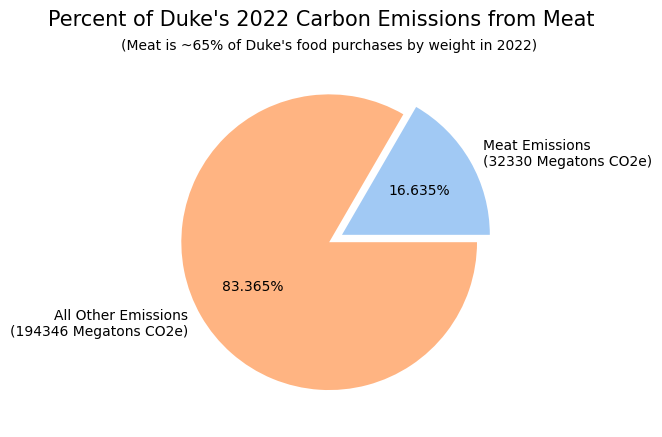

In [38]:
data = [16.635, 83.365]
explode = [0.1, 0]
keys = ['Meat Emissions\n(32330 Megatons CO2e)', \
        'All Other Emissions\n(194346 Megatons CO2e)']

palette_color = seaborn.color_palette('pastel')
  
plt.pie(data, labels=keys, colors=palette_color, autopct='%.3f%%', \
        explode = explode)
plt.suptitle('Percent of Duke\'s 2022 Carbon Emissions from Meat', fontsize = 15)
plt.title('(Meat is ~65% of Duke\'s food purchases by weight in 2022)', fontsize = 10)

plt.show()

In [12]:
#from google.colab import files

#DD22.to_csv('DD22.csv', encoding = 'utf-8-sig') 
#files.download('DD22.csv')